In [148]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima


In [149]:
# Load the stock prices CSV file (adjust the path as needed)
file_path = "stock_prices_5m.csv"
df = pd.read_csv(file_path)

# If a datetime column exists, parse it as datetime and sort by time
if 'Datetime' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Datetime'])

# Ensure sorting by Ticker symbol first, then by datetime
df.sort_values(by=['Ticker', 'Datetime'], inplace=True)
df.reset_index(drop=True, inplace=True)





In [150]:
# Train-Test Split
def split_data(df, ticker, feature='Close', test_size=0.2):
    ticker_df = df[df['Ticker'] == ticker][['Datetime', feature]].copy()
    ticker_df.set_index('Datetime', inplace=True)
    
    # Remove NaN values
    ticker_df.dropna(inplace=True)
    
    # Infer and set frequency
    inferred_freq = pd.infer_freq(ticker_df.index)
    if inferred_freq is None:
        inferred_freq = '5T'  # Default to 5-minute intervals
    ticker_df = ticker_df.asfreq(inferred_freq)
    
    train_size = int(len(ticker_df) * (1 - test_size))
    train, test = ticker_df[:train_size], ticker_df[train_size:]
    
    # Ensure data is not empty
    if train.empty or test.empty:
        raise ValueError("Train or test set is empty. Check data availability.")
    
    return train, test

 


In [151]:
# Automatically Determine Best ARIMA Order
def find_best_arima_order(train):
    train = train.dropna()
    if train.empty:
        raise ValueError("Training data contains only NaN values after cleaning.")
    auto_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    return auto_model.order  # Returns (p, d, q)

# ARIMA Model Training
def train_arima(train):
    if train.nunique().values[0] == 1:
        raise ValueError("Train data has constant values, ARIMA cannot fit.")
    
    try:
        best_order = find_best_arima_order(train)
        print(f"Best ARIMA Order Found: {best_order}")
        model = sm.tsa.ARIMA(train, order=best_order)
        fitted_model = model.fit()
        return fitted_model
    except Exception as e:
        raise ValueError(f"ARIMA training failed: {e}")


In [152]:
# ARIMA Prediction
def predict_arima(model, test):  
    test = test.dropna()
    try:
        steps = len(test)
        forecast = model.forecast(steps=steps)
        forecast_index = test.index  # Ensure predictions align with actual timestamps
        forecast_series = pd.Series(forecast, index=forecast_index)
        return forecast_series
    except Exception as e:
        raise ValueError(f"ARIMA forecasting failed: {e}")

In [153]:
# Plot Actual vs Predicted Data
def plot_predictions(actual, predicted):
    plt.figure(figsize=(10, 5))
    plt.plot(actual.index, actual, label='Actual Prices', color='blue')
    plt.plot(predicted.index, predicted, label='Predicted Prices', color='red')
    plt.xlabel('Datetime')
    plt.ylabel('Stock Price')
    plt.title('Actual vs Predicted Stock Prices')
    plt.legend()
    plt.show()


In [154]:
# Hyperparameter Tuning
def tune_hyperparameters():
    best_model = None
    best_loss = float("inf")
    best_params = None
    
    for lr in [0.01, 0.001, 0.0001]:
        for batch_size in [16, 32, 64]:
            model = build_lstm_model((50, 1))
            model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
            history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
            loss = min(history.history['val_loss'])
            
            if loss < best_loss:
                best_loss = loss
                best_model = model
                best_params = (lr, batch_size)
    
    return best_model, best_params

In [155]:
# Prediction
def predict_future(model, X_test, scaler):
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions.reshape(-1, 1))


In [156]:
# Plot Results
def plot_predictions(actual, predicted):
    plt.figure(figsize=(10, 5))
    plt.plot(actual, color='blue', label='Actual Price')
    plt.plot(predicted, color='red', label='Predicted Price')
    plt.legend()
    plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_12884\1770367979.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  ticker_df = ticker_df.asfreq(inferred_freq)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3330.770, Time=3.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3347.588, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3332.193, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3332.741, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3345.651, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3335.014, Time=2.97 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3334.965, Time=1.75 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3329.123, Time=4.00 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3337.396, Time=1.36 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3329.850, Time=4.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3327.641, Time=4.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3329.146, Time=4.77 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3330.311, Time=6.41 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3329.529, Time=9.19 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept

c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ASUS\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


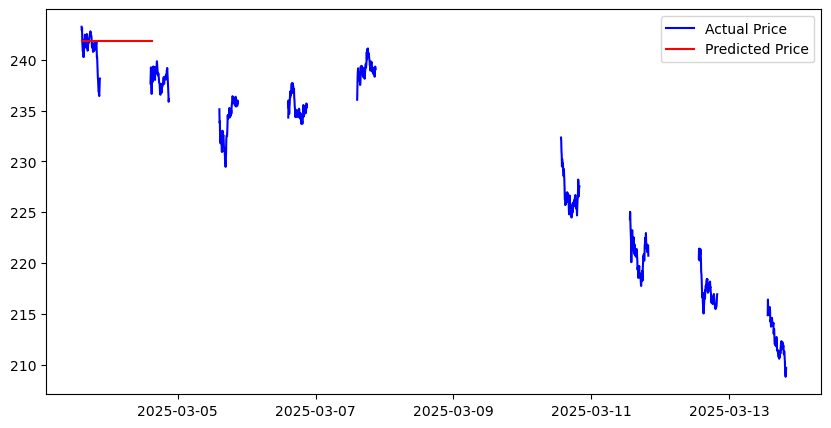

In [157]:
# Example Workflow
ticker_symbol = "AAPL"
train, test = split_data(df, ticker_symbol)
arima_model = train_arima(train)
arima_forecast = predict_arima(arima_model, test)
plot_predictions(test, arima_forecast) 

